In [1]:
import os
import numpy as np
from phathom import io
import tifffile
from phathom.segmentation import graphcuts
from phathom.preprocess import filtering
from phathom import plotting
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import label

In [3]:
import warnings
# warnings.filterwarnings('error', append=True)  # For RuntimeWarnings caught in graphcuts

In [3]:
%matplotlib notebook

In [2]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181206_eF9_A34_1/'

In [4]:
syto16_path = 'syto16.zarr/1_1_1'

syto16 = io.zarr.open(os.path.join(working_dir, syto16_path))
syto16.shape, syto16.dtype

((650, 2364, 2376), dtype('uint16'))

# Foreground mask graph cuts

In [6]:
syto16_smooth_path = 'syto16_smooth.zarr'

syto16_smooth = io.zarr.new_zarr_like(os.path.join(working_dir, syto16_smooth_path), syto16)
syto16.shape, syto16.dtype

((650, 2364, 2376), dtype('uint16'))

In [7]:
sigma = (0.7, 1.2, 1.2)
chunks = (256, 256, 256)
overlap = 8
nb_workers = None

filtering.gaussian_blur_parallel(syto16, sigma, syto16_smooth, chunks, overlap, nb_workers)

100%|██████████| 300/300 [00:26<00:00, 11.53it/s]


<IPython.core.display.Javascript object>


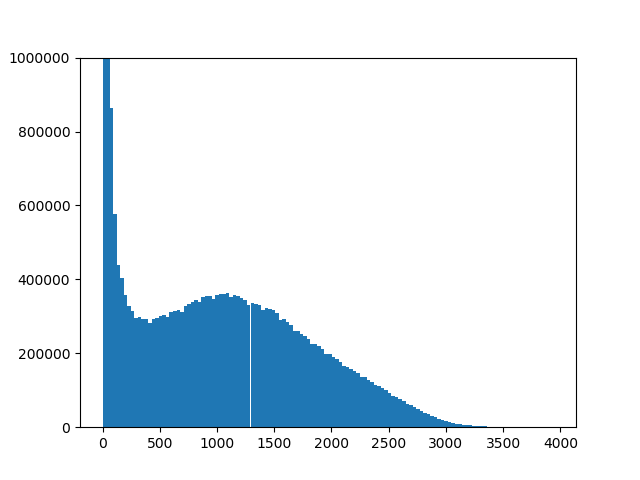

In [16]:
subvolume = syto16_smooth[200:208]

plt.figure()
plt.hist(subvolume.ravel(), bins=128)
plt.ylim([0, 1e6])
plt.show()

In [8]:
foreground_path = 'foreground2.zarr'

foreground = io.zarr.new_zarr(os.path.join(working_dir, foreground_path), 
                              syto16.shape, 
                              syto16.chunks, 
                              np.uint8)

In [10]:
overlap = 16
chunks = (128, 128, 128)
nb_workers = 12
kwargs = {'back_mu': 150,
          'obj_mu': 1000,
          'w_const': 10}

graphcuts.parallel_graph_cuts(syto16_smooth, foreground, overlap, chunks, nb_workers, **kwargs)


  0%|          | 0/2166 [00:00<?, ?it/s]/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/

 42%|████▏     | 911/2166 [05:33<11:10,  1.87it/s]


 66%|██████▌   | 1420/2166 [08:52<05:40,  2.19it/s]


 94%|█████████▍| 2038/2166 [11:24<00:10, 11.79it/s]


100%|██████████| 2166/2166 [11:32<00:00,  3.13it/s]

<IPython.core.display.Javascript object>


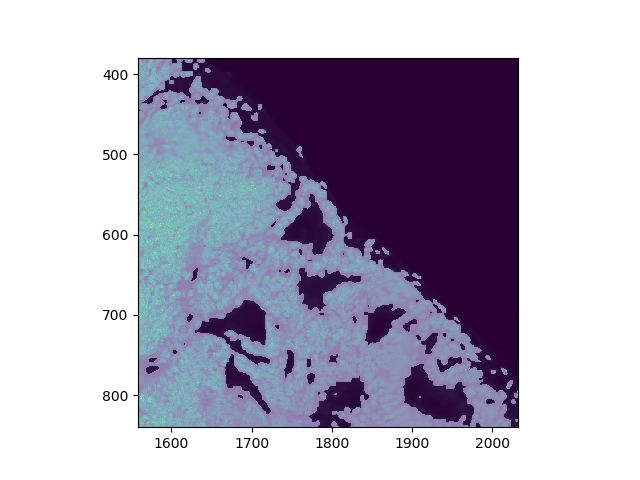

In [11]:
plt.imshow(syto16[200])
plt.imshow(foreground[200], alpha=0.4, cmap='gray')
plt.show()

# Foreground extraction based on probability map

In [5]:
prob_path = 'nuclei_probability.zarr'

prob = io.zarr.open(os.path.join(working_dir, prob_path))
prob.shape

(650, 2364, 2376)

<IPython.core.display.Javascript object>


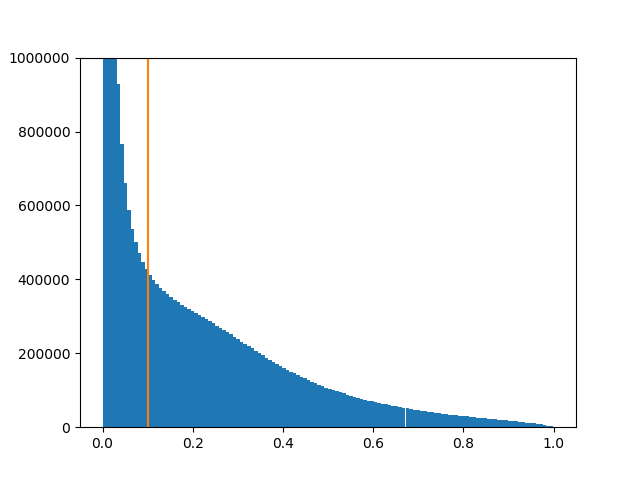

In [10]:
subvolume = prob[300:308]

threshold = 0.1

ylim = [0, 1e6]
plt.figure()
plt.hist(subvolume.ravel(), bins=128)
plt.plot([threshold, threshold], ylim)
plt.ylim(ylim)
plt.show()

In [7]:
prob_arr = prob[:]

In [8]:
foreground = (prob_arr > threshold).astype(np.uint8)

<IPython.core.display.Javascript object>


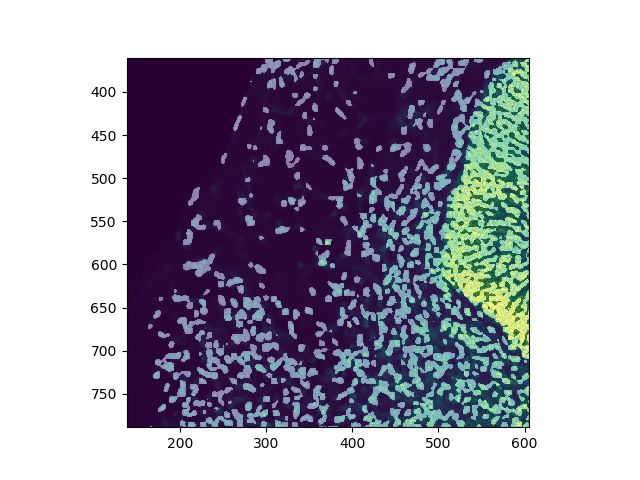

In [11]:
plt.imshow(syto16[300], clim=[0, 4000])
plt.imshow(foreground[300], alpha=0.4, cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


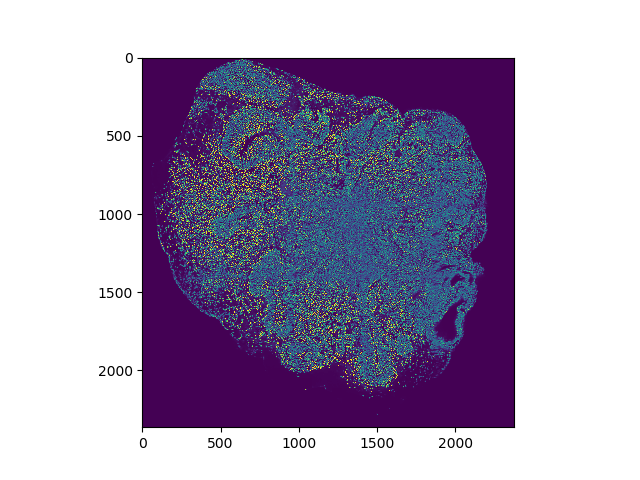

In [12]:
plt.imshow(prob[300], clim=[0, 0.8])
plt.show()

In [13]:
tifffile.imsave(os.path.join(working_dir, 'foreground.tif'), foreground, compress=1)

In [15]:
foreground_path = 'foreground.zarr'

foreground_zarr = io.zarr.new_zarr(os.path.join(working_dir, foreground_path), 
                                   prob.shape, 
                                   prob.chunks, 
                                   np.uint8)
foreground_zarr[:] = foreground

In [16]:
centers_path = 'centers.npy'

centers = np.load(os.path.join(working_dir, centers_path))
centers.shape

(2421822, 3)

<IPython.core.display.Javascript object>


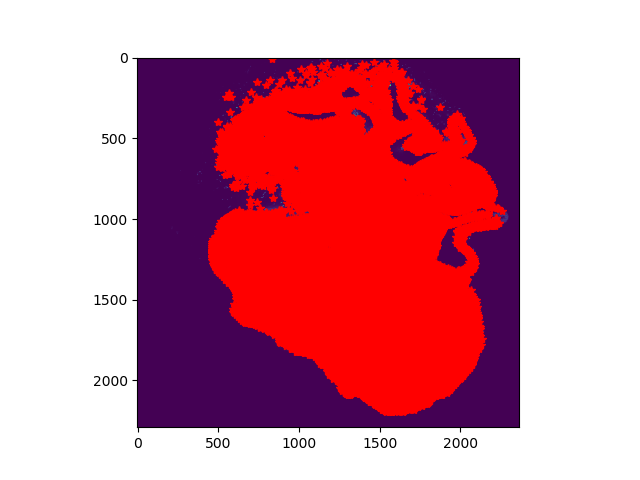

In [15]:
plotting.zprojection(prob, centers, zlim=[400, 408])

In [17]:
from phathom.segmentation import segmentation

In [18]:
segmentation_path = 'segmentation.zarr'

seg = io.zarr.new_zarr(os.path.join(working_dir, segmentation_path), 
                       prob.shape, 
                       prob.chunks, 
                       np.uint8)

In [19]:
chunks = (256, 256, 256)
overlap = 32
nb_workers = 12

segmentation.watershed_centers_parallel(prob, centers, foreground_zarr, seg, chunks, overlap, nb_workers)

100%|██████████| 300/300 [21:32<00:00,  4.31s/it]  


In [20]:
del foreground
del prob_arr

# Label the nuclei

In [21]:
labels, nb_lbls = label(seg[:])
print(nb_lbls)

2414061


In [22]:
print(centers.shape)

(2421822, 3)


In [23]:
tifffile.imsave(os.path.join(working_dir, 'pseg_compressed.tif'), labels.astype(np.float32), compress=1)

In [22]:
np.save(os.path.join(working_dir, 'nuclei_segmentation.npy'), labels)

In [29]:
del labels

# Watershed in memory all at once (old)

In [30]:
from phathom.synthetic import points_to_binary

In [31]:
image = -prob[:]
markers = label(points_to_binary(tuple(centers.T), image.shape, cval=1))[0]
mask = foreground[:]

seg = morphology.watershed(image, markers, mask=mask, watershed_line=True)

MemoryError: 

In [17]:
seg.shape

(256, 512, 512)

In [16]:
import matplotlib
cmap = matplotlib.colors.ListedColormap(np.vstack((np.zeros((1, 3)), np.random.rand(centers.shape[0]-1, 3))))

<IPython.core.display.Javascript object>


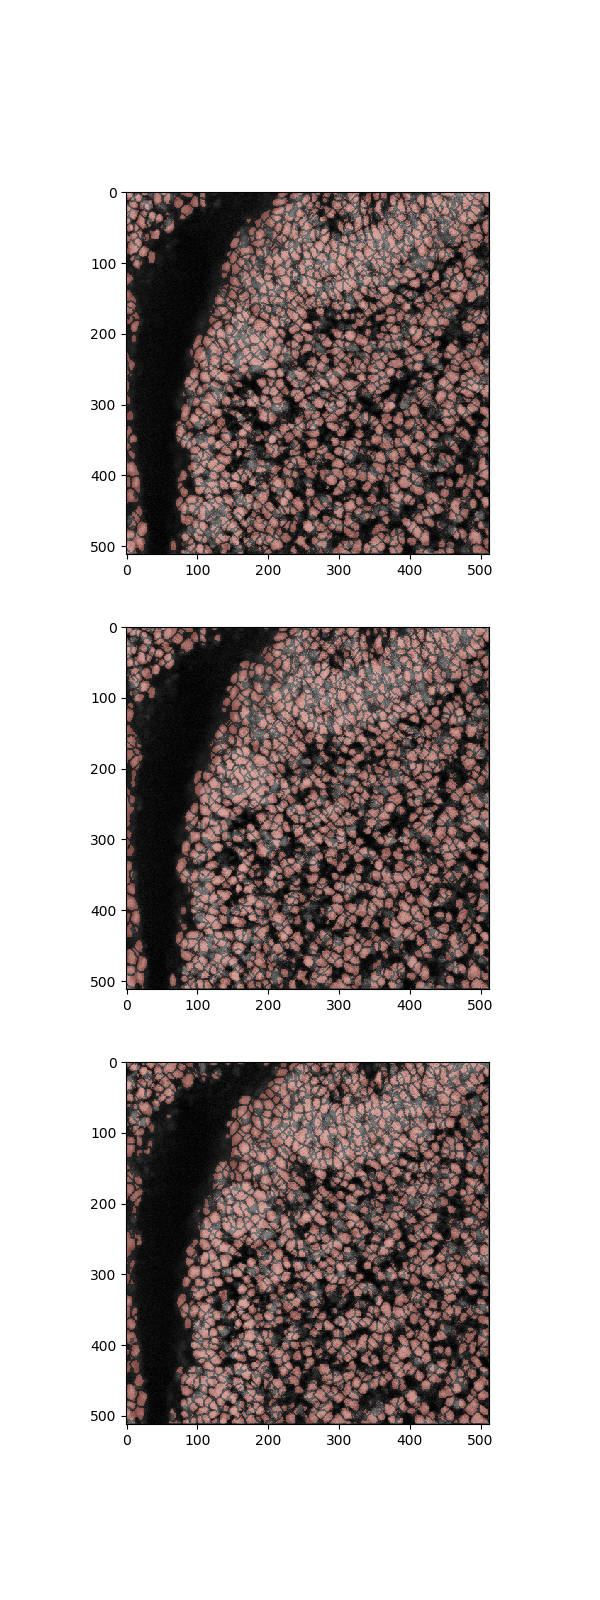

In [17]:
plt.figure(figsize=(6, 16))
plt.subplot(311)
plt.imshow(syto16[16], cmap='gray')
plt.imshow(seg[16], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.subplot(312)
plt.imshow(syto16[18], cmap='gray')
plt.imshow(seg[18], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.subplot(313)
plt.imshow(syto16[20], cmap='gray')
plt.imshow(seg[20], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.show()

In [35]:
import tifffile

In [37]:
tifffile.imsave(os.path.join(working_dir, 'syto16_test.tif'), syto16[:].astype(np.float32))
tifffile.imsave(os.path.join(working_dir, 'seg.tif'), seg.astype(np.float32))